In [39]:
# Setting up logger
import logging

fileh = logging.FileHandler('./dijkstra_nx.log', 'a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fileh.setFormatter(formatter)

log = logging.getLogger()  # root logger
for hdlr in log.handlers[:]:  # remove all old handlers
    log.removeHandler(hdlr)
log.addHandler(fileh)      # set the new handler

In [40]:
# Importing packages
%matplotlib inline
import matplotlib.pyplot as plt
import random
import copy
import heapq
import networkx as nx
import time
from collections import deque, namedtuple

# Setting preliminary constants
# inf: as a default distance to nodes
# time_threshold: threshold time for the rebuilding of the quantum link
# original_capacity: original capacity of the quantum link
# original_cost: cost of using the link
# Edge: create Edge object of the graph

inf = float('inf')
time_threshold = 10000
original_capacity = 4
rebuild_probability = 0.25
number_of_nodes = 32
number_of_sd_pairs = 50
number_of_samples = 100

# Edge object of a graph
Edge = namedtuple('edge', 'end, capacity')


# Method adding an edge in the graph


def make_edge(start, end, capacity=original_capacity):
    return Edge(start, end, capacity)


def make_backward_edge(start, end, capacity=original_capacity):
    return Edge(end, start, capacity)


# def make_backward_edge(start, end, capacity=original_capacity):
#   return Edge(end, start, capacity)


''' 
Deleting an entry from dictionary using del and try/except  
'''


def delete_key(dict, key):
    # If key is not present in dictionary, then del can throw KeyError
    try:
        del dict[key]
    except KeyError:
        print(key + " not found in the dictionary.")


class Vertex:
    def __init__(self, vertex):
        self.name = vertex
        self.neighbours = {}

    # Storing the indices of neighbouring vertices
    def add_neighbour(self, neighbour, capacity=1):
        if neighbour not in self.neighbours:
            self.neighbours[neighbour] = capacity
        else:
            return False

    def add_neighbours(self, neighbours):
        for neighbour in neighbours:
            if isinstance(neighbour, tuple):
                self.add_neighbour(neighbour[0], neighbour[1])
            else:
                self.add_neighbour(neighbour)

    def __repr__(self):
        return str(self.neighbours)


class Graph:

    # Check that the arguments are valid
    def __init__(self, edges=None):
        self.Vertices = {}

        # Initializing graph based on edges
        if edges is not None:
            wrong_edges = [i for i in edges if len(i) not in [2, 4]]
            if wrong_edges:
                raise ValueError('Wrong edges data: %s', wrong_edges)

            # Adding bidirectional links
            for current_edge in edges:

                # Adding onward link
                if current_edge[0] not in self.Vertices.keys():
                    self.Vertices[current_edge[0]] = Vertex(current_edge[0])

                self.Vertices[current_edge[0]].add_neighbour(current_edge[1], original_capacity)

                # Adding backward link
                if current_edge[1] not in self.Vertices.keys():
                    self.Vertices[current_edge[1]] = Vertex(current_edge[1])

                self.Vertices[current_edge[1]].add_neighbour(current_edge[0], original_capacity)

    @property
    def vertices(self):
        return self.Vertices

    def vertex(self, vertex):
        try:
            self.vertices[vertex]
        except:
            log.debug("No such start node found among the vertices.")
        return self.vertices[vertex]

    def edge(self, start_node, end_node):

        try:
            self.vertex(start_node).neighbours[end_node]
        except:
            log.debug("No such end node found among the vertices.")
        return self.vertices[start_node].neighbours[end_node]

    def add_vertex(self, vertex):
        if isinstance(vertex, Vertex):
            self.Vertices[vertex.name] = vertex.neighbours

    def add_vertices(self, vertices):
        for vertex in vertices:
            self.add_vertex(vertex)

    def add_edge(self, vertex_from, vertex_to):
        if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
            vertex_from.add_neighbour(vertex_to)
            if isinstance(vertex_from, Vertex) and isinstance(vertex_to, Vertex):
                self.Vertices[vertex_from.name] = vertex_from.neighbours
                self.Vertices[vertex_to.name] = vertex_to.neighbours

    def add_edges(self, edges):
        for edge in edges:
            self.add_edge(edge[0], edge[1])

    def access_edge(self, start_node, end_node):

        try:
            self.vertices[start_node]
        except KeyError:
            log.debug("No such start node found among the vertices.")
        try:
            self.vertices[start_node].neighbours[end_node]
        except KeyError:
            log.debug("No such end node found among the vertices.")
        return self.vertices[start_node].neighbours[end_node]


'''
Distance defined in a ring graph
'''


def dist(graph, start_node, end_node):
    return min(abs(start_node - end_node), graph.number_of_nodes() + start_node - end_node)


'''
Get current capacity of a specific link
'''


def link_capacity(graph, startNode):
    # Assembling node pairs into a list
    node_pairs = [[startNode, endNode], [endNode, startNode]]
    edges = graph.edges[:]
    for this_edge in edges:
        if [this_edge.start, this_edge.end] in node_pairs:
            return this_edge.capacity


'''
Adds a link to the network specified by a pair of nodes, the capacity
Assembling node pairs into a list
'''


def add_link(graph, startNode, endNode, capacity=original_capacity):
    node_pairs = [[startNode, endNode], [endNode, startNode]]
    edges = graph.edges[:]
    for this_edge in edges:
        if [this_edge.start, this_edge.end] in node_pairs:
            graph.edges.remove(this_edge)

            # Add bidirectional link
            graph.edges.append(Edge(startNode, endNode, capacity))
            graph.edges.append(Edge(endNode, startNode, capacity))

'''
Remove a link specified by the start and end node
'''


def remove_link(graph, start_node, end_node):
    try:
        graph[start_node][end_node]['capacity'] = graph[start_node][end_node]['capacity'] -1
    except KeyError:
        print("Key 'testing' not found")


'''
Processes a source-destination pair of distance one of the current path
by checking the capacity of the link between the start and the end node

If the capacity is 0, then a probabilistic rebuild approach is used

Returns the elapsed time that was needed to process the particular source-destination pair

If the capacity of the link is 0, then
do probabilistic rebuilding

Otherwise: 
Consumes a link from the remaining ones
Alternatively: add the threshold waiting time for rebuilding
'''


def process_step(graph, start_node, end_node):
    local_edt = 0

    if graph[start_node][end_node]['capacity'] == 0:

        classical_distance = dist(graph, start_node, end_node)

        for x in range(1, classical_distance + 1):

            # Probabilistic link creation
            while rebuild_probability * 100 < random.randint(1, 100):
                local_edt += 1
    else:

        # Remove the link between startNode and endNode
        remove_link(graph, start_node, end_node)

        # Incrementing the entanglement delay time
        local_edt += 1

    return local_edt


'''
# Works through a source-destination pair by traversing through the nodes in between and adding the elapsed time
#
# Calls on the process_step method as many times as big the distance between the source and the destination is
'''


def process_path(graph, current_path):
    log.debug('current path: %s', current_path)

    # Initializing entanglement delay time
    edt = 0

    # Take the leftmost two nodes out of the deque and get the edt until we are finished

    while True:

        start_node = current_path.popleft()
        end_node = current_path.popleft()

        # Calculate the edt for the current step
        edt += process_step(graph, start_node, end_node)

        # Check if we have processed the path
        if len(current_path) == 0:
            return edt

        # Put the end node back into the deque
        current_path.appendleft(end_node)


'''
Relaxation part of the Dijkstra algorithm

'''


def relaxation(graph: Graph, distances: dict, previous_vertices: dict, current_vertex: Vertex):
    # Relaxation procedure of the algorithm
    if distances[current_vertex] == inf:
        return
    for neighbour in graph.vertices[current_vertex].neighbours:
        alternative_route = distances[current_vertex] + 1
        if alternative_route < distances[neighbour]:
            distances[neighbour] = alternative_route
            previous_vertices[neighbour] = current_vertex


'''
Running the Initialize-Single-Source procedure
'''


def initialize_single_source(graph: Graph, source: Vertex) -> (dict, dict):
    distances = {vertex: inf for vertex in graph.vertices}
    previous_vertices = {vertex: None for vertex in graph.vertices}
    distances[source] = 0
    return distances, previous_vertices


'''
Finding the shortest path based on the Dijkstra algorithm
'''


def find_shortest(graph, source, dest) -> deque:
    distances = {vertex: inf for vertex in graph.vertices}
    previous_vertices = {vertex: None for vertex in graph.vertices}
    distances[source] = 0
    return distances, previous_vertices

'''
Generates random source-destination pairs
The number of source-destination pairs is given by the argument
'''


def gen_rand_pairs(number_of_pairs):
    result = []
    for x in range(number_of_pairs):
        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)
        while source == dest:
            dest = random.randint(1, number_of_nodes)
        result += [[source, dest]]
    return result


'''
Generates source-destination pairs and finds the nodes in between them by calling on the dijkstra method
'''


def initialize_paths(graph: Graph, number_of_source_destination_pairs: int):
    # Generate random pairs of nodes between which we are seeking a path
    rand_pairs = gen_rand_pairs(number_of_source_destination_pairs)

    # Assemble paths into one deque
    paths = deque()
    for pair in rand_pairs:
        paths.appendleft(deque(nx.shortest_path(graph, pair[0], pair[1])))
    return paths


'''
Sending packets based on the generated source destination pairs
Processes these pairs by calling the process_path method on the next path
Processes each of the paths stored in the deque and pushes the result edt into a store
'''


def send_packets(graph, paths):
    edt_store = []

    # Process the next path in the deque
    for current_path in paths:
        edt_store.append(process_path(graph, current_path))

    return edt_store


def send_packet(graph, path):
    process_path(graph, current_path)
                
def global_algo(graph: Graph, number_of_source_destination_pairs: int):
    
    edts = []

    # Storing the distances of the paths
    distance_store = []
    for x in range(1, number_of_source_destination_pairs+1):
        
        source = random.randint(1, number_of_nodes)
        dest = random.randint(1, number_of_nodes)
        
        while source == dest:
            dest = random.randint(1, number_of_nodes)
        rand_pairs = gen_rand_pairs(number_of_source_destination_pairs)
        current_path = deque(nx.shortest_path(graph, source, dest))
        edts.append(process_path(graph, current_path))
        distance_store.append(len(current_path))
    return [edts, distance_store]
        
        
def dijkstra(graph: Graph, number_of_source_destination_pairs: int):
    # start = time.time()
    path_store = initialize_paths(graph, number_of_source_destination_pairs)

    # Storing the distances of the paths
    distance_store = []
    for current_path in path_store:
        distance_store.append(len(current_path))

    # Calculating the entanglement delay times
    edts = send_packets(graph, path_store)

    # logging.debug("Total time: %s", (end - start))
    # logging.debug(graph.edges)
    return [edts, distance_store]


def mean(numbers):
    try:
        return float(sum(numbers)) / max(len(numbers), 1)
    except Exception:
        print('valami')


def loop_main(graph: Graph, number: int, algorithm: str) -> list:
    avg_edts = []

    if algorithm == 'dijkstra':          
        for x in range(1, number + 1):
            [edts, distances] = dijkstra(graph, x)
            avg_edts.append(mean(edts))
    elif algorithm == 'global_algo':
        for x in range(1, number + 1):
            [edts, distances] = global_algo(graph, x)
            avg_edts.append(mean(edts))
    return [avg_edts, distances]


def add_capacities(graph):
    for edge in graph.edges:
        graph[edge[0]][edge[1]]['capacity'] = 4

if __name__ == "__main__":
    graph1 = nx.Graph()
    graph2 = nx.Graph()
    graph3 = nx.Graph()
    
    graph1.add_edges_from(

        # Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
        [(x, x + 1, {'capacity': original_capacity}) for x in range(1, number_of_nodes)] + [(number_of_nodes, 1)]
    )
    
    graph2.add_edges_from(

        # Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
        [(x, x + 1, {'capacity': original_capacity}) for x in range(1, number_of_nodes)] + [(number_of_nodes, 1)] +

        # Iniating the edges of 1) type: 1->3, 3->5, ... 31->1
        # Odd number of nodes
        [(x, x + 2, {'capacity': original_capacity}) for x in range(1, number_of_nodes + 1)
         if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +

        # Even number of nodes
        [(x, (x + 2) % number_of_nodes, {'capacity': original_capacity}) for x in range(1, number_of_nodes + 1) if
         x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0]
    )

    graph3.add_edges_from(

        # Iniating the edges of 0) type: 1->2, 2->3, ... 31->32, 32->1 (circular graph)
        [(x, x + 1, {'capacity': original_capacity}) for x in range(1, number_of_nodes)] + [(number_of_nodes, 1)] +

        # Iniating the edges of 1) type: 1->3, 3->5, ... 31->1

        # Even number of nodes
        [(x, (x + 2) % number_of_nodes, {'capacity': original_capacity}) for x in range(1, number_of_nodes + 1)
         if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 0] +

        # Odd number of nodes
        [(x, x + 2, {'capacity': original_capacity}) for x in range(1, number_of_nodes + 1)
         if x % 2 == 1 and x < number_of_nodes and number_of_nodes % 2 == 1] +

        # Iniating the edges of 2) type: 1->5, 5->9, ... 29->1
        # Number of nodes have 0 as remainder for modulo 4
        [(x, x + 4, {'capacity': original_capacity}) for x in range(1, number_of_nodes - 3) if x % 4 == 1 and number_of_nodes % 4 == 0] + [
            (number_of_nodes - 3, 1) for x in range(1, 2) if number_of_nodes % 4 == 0]

    )

    add_capacities(graph1)
    add_capacities(graph2)
    add_capacities(graph3)
    
    # Simulation for more than one run of the loop_main
    def do_simulation(graph: Graph, sd_pair: int, samples: int, algorithm: str):
        [local_edts, local_distances] = loop_main(graph, sd_pair, algorithm)

        # Iterating through the remaining simulation rounds
        for x in range(1, samples):
            [next_edts, next_distances] = loop_main(graph, sd_pair, algorithm)

            # Summing up the values obtained in each round
            local_edts = [sum(x) for x in zip(local_edts, next_edts)]
            local_distances = [sum(x) for x in zip(local_distances, next_distances)]

        # Returning the average of the result values
        return [[x / samples for x in local_edts], [x / samples for x in local_distances]]

In [41]:
start = time.time()
[avg_edts1, distances1] = do_simulation(graph1, number_of_sd_pairs, number_of_samples, 'dijkstra')
[avg_edts2, distances2] = do_simulation(graph2, number_of_sd_pairs, number_of_samples, 'dijkstra')
[avg_edts3, distances3] = do_simulation(graph3, number_of_sd_pairs, number_of_samples, 'dijkstra')
end = time.time()
print(end-start)

7.214072942733765


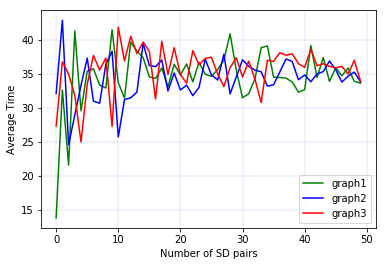

In [42]:
plt.plot(avg_edts1,color='green', label="graph1")
plt.plot(avg_edts2, color='blue', label="graph2")
plt.plot(avg_edts3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Average Time')
plt.legend()
plt.show()

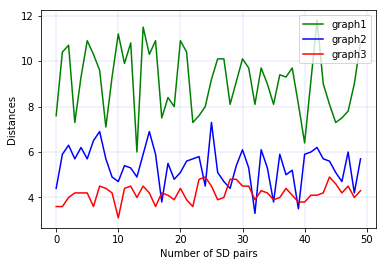

In [43]:
plt.plot(distances1,color='green', label="graph1")
plt.plot(distances2, color='blue', label="graph2")
plt.plot(distances3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Distances')
plt.legend()
plt.show()

# Global algorithm

In [17]:
start = time.time()
[avg_edts1, distances1] = do_simulation(graph1, number_of_sd_pairs, number_of_samples, 'global_algo')
[avg_edts2, distances2] = do_simulation(graph2, number_of_sd_pairs, number_of_samples, 'global_algo')
[avg_edts3, distances3] = do_simulation(graph3, number_of_sd_pairs, number_of_samples, 'global_algo')
end = time.time()
print(end-start)

86.29788255691528


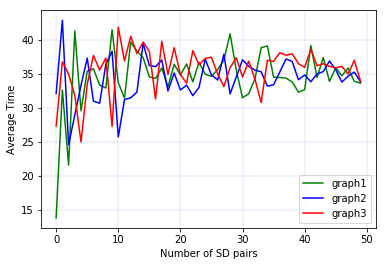

In [44]:
plt.plot(avg_edts1,color='green', label="graph1")
log.debug("avg_edt for graph 1 %s: ")
log.debug(avg_edts1)
plt.plot(avg_edts2, color='blue', label="graph2")
log.debug("avg_edt for graph 2 %s: ")
log.debug(avg_edts2)
plt.plot(avg_edts3, color='red', label="graph3")
log.debug("avg_edt for graph 3 %s: ")
log.debug(avg_edts3)
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Average Time')
plt.legend()
plt.show()

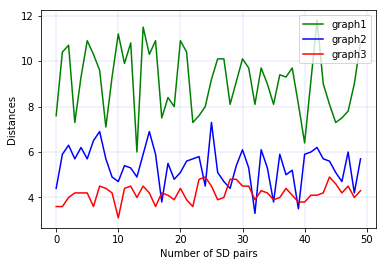

In [45]:
plt.plot(distances1,color='green', label="graph1")
plt.plot(distances2, color='blue', label="graph2")
plt.plot(distances3, color='red', label="graph3")
plt.grid(color='b', linestyle='-', linewidth=0.1)
plt.xlabel('Number of SD pairs')
plt.ylabel('Distances')
plt.legend()
plt.show()

In [20]:
print(distances3)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
